# Exercícios da Aula 10 - Descritores Binários
### Samuel Felipe dos Santos

#### Bibliotecas usadas

In [4]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import euclidean

#### Funções  Reaproveitadas de Aulas Anteriores

As funções a seguir foram reaproveitadas de aulas anteriores.

Abaixo é mostrado as funções de padding, correlação e normalização

In [5]:
#Implementação de padding com zeros utilizado pela função de correlação 
def pad(image, u,d,l,r):
    paded_image = np.zeros([image.shape[0]+u+d, image.shape[1]+l+r])
    paded_image[u:paded_image.shape[0]-d, l:paded_image.shape[1]-r] = image
    return paded_image

#Implementação da função de correlação entre uma imagem e uma máscara
def correlation(image, mask, function=np.sum):
    u = int(mask.shape[0]/2)
    d = mask.shape[0]-1-u
    l = int(mask.shape[1]/2)
    r = mask.shape[1]-1-l
    
    img_shape = image.shape
    p_image = pad(image, u, d, l, r)
    
    out = np.zeros(img_shape[:2])
    for i in range(u, u+img_shape[0]-1):
        for j in range(l, l+img_shape[1]-1):
            out[i-u,j-l] = function( mask *  p_image[ i-u :i+1+d, j-l:j+1+r ] )
    return out

#faz com que os pixels da imagem variem entre os valores de  img_min e img_max
def rescale(img, img_min, img_max):
    mn = img.min()
    mx = img.max()
    return ((img-mn)/(mx-mn)*(img_max-img_min) + img_min)

Abaixo é mostrada as classes que implementam operadores morfológicos. $morphological\_op$ aplica erosão ou dilatação, $opening$ aplica abertura e $closing$ aplica o fechamento.

In [6]:
class morphological_op:
    def __init__( self, mask, op = 'dilation' ):
        self.n_mask = np.sum(mask)
        self.mask = mask
        self.op = op
        
    def func( self, crop ):        
        if self.op == 'erosion':
            threshold = self.n_mask
        else:
            threshold = 1
 
        if np.sum( crop ) >= threshold:
            return 1
        else:
            return 0
    
    def run( self, img ):
        return correlation(img, self.mask, function=self.func)
        
class opening:
    def __init__( self, mask ):
        self.erosion  = morphological_op( mask, 'erosion' )
        self.dilation = morphological_op( mask, 'dilation')
    
    def run(self, img):
        out = self.erosion.run(img)
        out = self.dilation.run(img)
        return out

class closing:
    def __init__( self, mask ):
        self.erosion  = morphological_op( mask, 'erosion' )
        self.dilation = morphological_op( mask, 'dilation')
    
    def run(self, img):
        out = self.dilation.run(img)
        out = self.erosion.run(img)
        return out

### Excercício 1:

- **Adapte o algoritmo de orientação de contorno para que a entrada não precise ser o contorno de um objeto, mas o próprio objeto**

- **Adapte o algoritmo para lidar com problemas de contornos finos**
    - **Pode usar um pré-processamento**

Para implementar o algoritmo de orientação de contorno foram criadas funções para verificar se um ponto faz parte da imagem, criar uma vizinhança de pontos no sentido horário e encontrar um ponto inicial para rodar  algoritmo.

In [7]:
#verifica se o ponto de coordenadas [i,j] esta dentro da imagem de dimensões shape
def valid_point( shape, i,j ):
    if i>=0 and i<shape[0] and j>=0 and j<shape[1]:
        return True
    else:
        return False

#retorna uma lista com a vizinhança quadrada no sentido horario de raio radius ao redor do ponto [x,y]
def square_neighborhood( x, y, shape, radius=1 ):
    neighbors = []
    for r in range(1,radius+1):
        
        for i in range(0,-r,-1):
            if valid_point( shape, x+i, y-r ):
                neighbors += [[ x+i, y-r ]]
        
        for i in range(-r,r):
            if valid_point( shape, x-r, y+i ):
                neighbors += [[ x-r, y+i ]]
        
        for i in range(-r,r):
            if valid_point( shape, x+i, y+r ):
                neighbors += [[ x+i, y+r ]]
        
        for i in range(r,-r,-1):
            if valid_point( shape, x+r, y+i ):
                neighbors += [[ x+r, y+i ]]
                
        for i in range(r,0,-1):
            if valid_point( shape, x+i, y-r ):
                neighbors += [[ x+i, y-r ]]
            
    return neighbors

#encontra um ponto para iniciar o algoritmo
def find_start_point( img ):
    for i in range( img.shape[1] ):
        for j in range( i+1 ):
            if img[i,j] == 1:
                return (i,j)
            elif img[j,i] == 1:
                return (i,j)

Para fazer com que o algoritmo possa ser executado em objetos, o contorno é extraído durante o preprocessamento com o algoritmo de Canny.

Foi implementada então a função de orientação de contorno.

Nela, o ponto inicial é definido por padrão pela função implementada anteriormente, e é usada uma vizinhança quadrada em sentido horário, com 8 elementos.  

A função segue os passos abaixo.

1. O ponto inicial é o primeiro analisado;
2. $c0$ é definido como o pixel a esquerda  do ponto inicial e é de fundo.
3. Seguindo rotação horária na vizinhança do pixel analisado, a partir do pixel $c0$, o primeiro pixel com valor diferente de zero encontrado é definido como fazendo parte do contorno;
4. O pixel encontrado será o proximo pixel analisado;
5. $c0$ passa a ser o pixel analisado nessa iteração;
6. Os passos 1 a 5 são repetidos até serem analisados novamente o primeiro e segundo pixel do contorno;
7. O algortimo também para se um limite máximo de iterações for atingida.

Como saída, tem-se uma lista de pontos com o contorno ordenado da imagem.

O código pode ser visto a seguir.

In [8]:
def get_contour( img ):
    return cv.Canny(img.astype('uint8'), 100, 200, True, 7 )

def contour_ordering( img, start_point, neighborhood=square_neighborhood, radius=1, preprocessing=None,
                      max_iterations = 100000 ):

    if preprocessing is not None:
        img = preprocessing(img)
    
    points = []
    (x,y) = start_point
    (c0x, c0y) = [x, y-1]
    
    shape = img.shape
    out = np.zeros(shape, dtype='uint8')
    success = True
    end = False
    neighbors = []
    t=1
    while not end:
        points += [[x,y]]
        neighbors = neighborhood(x,y, shape, radius)
        found = False
        
        for k in range(len(neighbors)):
            (i,j) = neighbors[k]
            if (i,j) == (c0x, c0y):
                break
        neighbors = neighbors[k+1:] + neighbors[:k] 

        for (i,j) in neighbors:
            if img[i,j] != 0:
                (c0x, c0y) = (x,y)
                (x,y) = (i,j)
                found = True
                break
                
        if t>=max_iterations:
            success = False
            end = True
        elif (len(points)>2 and points[-2] == points[0] and  points[-1] == points[1]) or t>=max_iterations:
            end = True
        elif not found:
            (temp_x, temp_y) = (x, y)
            (x, y)     = (c0x, c0y)
            (c0x, c0y) = (temp_x, temp_y)
            
        t+=1
    return points[1:-1], success

A função a seguir converte a lista de pontos em uma imagem, onde cada pixel tem valor único crescente de acordo com sua posição na lista.
Se um ponto aparece 2 vezes na lista, a valor da primeira posição que ele apareceu é mantido.

In [26]:
def points_to_img( points, shape, h=1 ):
    img = np.zeros( shape, dtype='uint8' )
    for i,(x,y) in enumerate(points):
        if img[x,y] == 0:
            img[x,y] = i*h+1
    return img

A seguir o funcionamento do algortimo é testado nos exemplos mais simples apresentados em aula. Sendo mostrado que as funções funcionam corretamente.

In [10]:
img1 = np.array([[0,0,0,0,0,0,0],
                 [0,0,1,1,1,1,0],
                 [0,1,0,0,1,0,0],
                 [0,0,1,0,1,0,0],
                 [0,1,0,0,1,0,0],
                 [0,1,1,1,1,0,0],
                 [0,0,0,0,0,0,0]])

img2 = np.array([[0,0,0,0,0,0,0],
                 [0,0,0,1,0,0,0],
                 [0,0,1,0,1,0,0],
                 [0,0,1,0,0,0,0],
                 [0,1,0,1,0,0,0],
                 [0,1,1,1,0,0,0],
                 [0,0,0,0,0,0,0]])

for (n,img) in enumerate([img1, img2]):
    print('exemplo',n,', contorno original:')
    print(img)
    (i,j) = find_start_point( img )
    c, s = contour_ordering( img, [i,j] )
    print('exemplo',n,', lista do contorno ordenado:')
    print(c)
    print('exemplo',n,', contorno ordenado:')
    print(points_to_img(c, img.shape ))
    print('\n')

exemplo 0 , contorno original:
[[0 0 0 0 0 0 0]
 [0 0 1 1 1 1 0]
 [0 1 0 0 1 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 0 1 0 0]
 [0 1 1 1 1 0 0]
 [0 0 0 0 0 0 0]]
exemplo 0 , lista do contorno ordenado:
[[1, 2], [1, 3], [1, 4], [1, 5], [2, 4], [3, 4], [4, 4], [5, 4], [5, 3], [5, 2], [5, 1], [4, 1], [3, 2], [2, 1]]
exemplo 0 , contorno ordenado:
[[ 0  0  0  0  0  0  0]
 [ 0  0  1  2  3  4  0]
 [ 0 14  0  0  5  0  0]
 [ 0  0 13  0  6  0  0]
 [ 0 12  0  0  7  0  0]
 [ 0 11 10  9  8  0  0]
 [ 0  0  0  0  0  0  0]]


exemplo 1 , contorno original:
[[0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 0 1 0 0 0 0]
 [0 1 0 1 0 0 0]
 [0 1 1 1 0 0 0]
 [0 0 0 0 0 0 0]]
exemplo 1 , lista do contorno ordenado:
[[1, 3], [2, 4], [1, 3], [2, 2], [3, 2], [4, 3], [5, 3], [5, 2], [5, 1], [4, 1], [3, 2], [2, 2]]
exemplo 1 , contorno ordenado:
[[ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  4  0  2  0  0]
 [ 0  0  5  0  0  0  0]
 [ 0 10  0  6  0  0  0]
 [ 0  9  8  7  0  0  0]
 [ 0  0  0  0  0  0  0]]




Abaixo são mostradas imagens de forma do conjunto de dados MPEG7 shapes (disponível em http://www.cis.temple.edu/~latecki/TestData/mpeg7shapeB.tar.gz) e o cortorno ordenado de cada um deles.

Como pode ser observado, foi possível ordernar o contorno das imagens com sucesso, como pode ser visto na imagem, onde cores mais próximas de amarelo representam valores mais altos.

É possível notar também que alguns trechos do contorno possivelmente foram percorridos mais de uma vez, devido a múltiplos trechos em amarelo não contínuos.

Todos os contornos foram fechados com sucesso. Não foi necessário a utilização de um método para lidar com bordas finas.


img 1 - contorno completo?: True
img 2 - contorno completo?: True
img 3 - contorno completo?: True
img 4 - contorno completo?: True


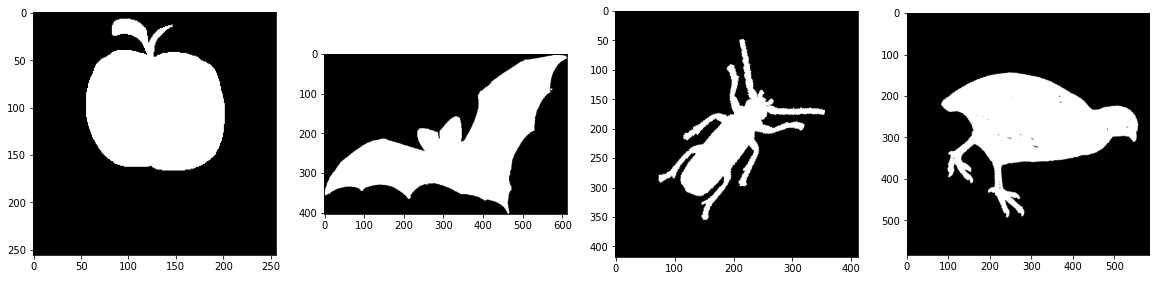

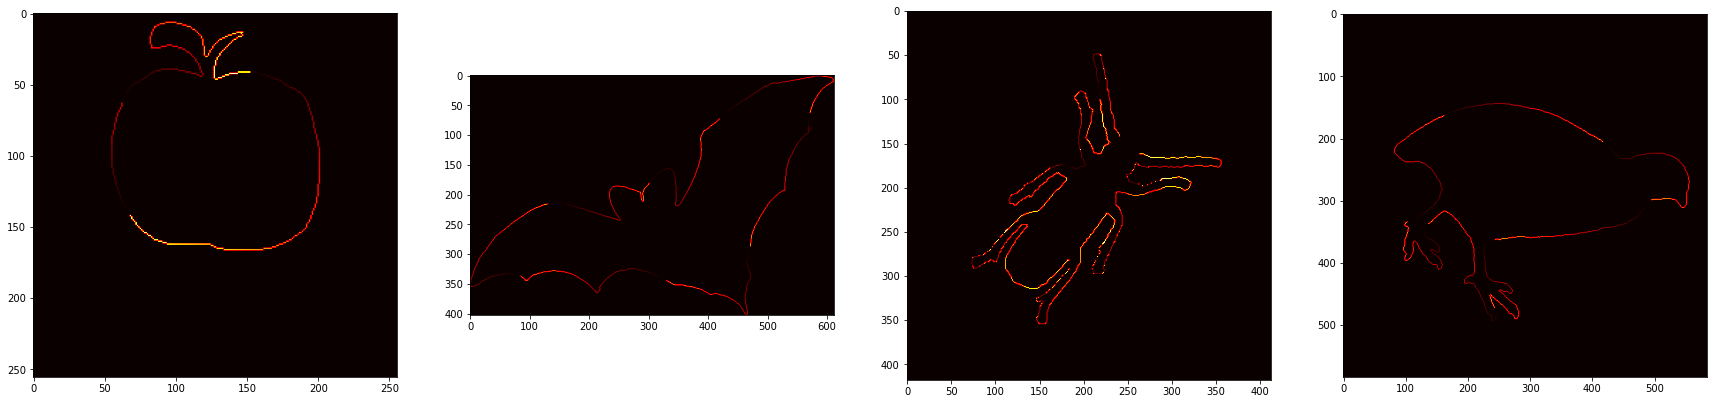

In [12]:
images_path = [ 'data/aula10/MPEG7shapes/apple-4.png',
                'data/aula10/MPEG7shapes/bat-18.png',
                'data/aula10/MPEG7shapes/beetle-10.png',
                'data/aula10/MPEG7shapes/bird-6.png']

fig = plt.figure(figsize=(20, 10))
imgs = []
for i,path in enumerate(images_path):
    img = rescale(cv.imread(path, 0), 0,1)
    imgs += [img]
    fig.add_subplot(1, 4, i+1)
    plt.imshow(img, cmap='gray')

fig = plt.figure(figsize=(30, 30))
for (i,img) in enumerate(imgs):
    contour_points, s = contour_ordering( img, find_start_point(img), preprocessing=get_contour,
                                          max_iterations=5000 )
    contour = points_to_img(contour_points, img.shape)
    
    print('img',i+1,'- contorno completo?:',s)
    
    fig.add_subplot(1, 4, i+1)
    plt.imshow(contour, cmap='hot')

A seguir o experimento foi repetido, mas dessa vez, foi aplicado a operação de abertura 3 vezes, com o objetivo de eliminar bordas finas. Foi usado padding também para evitar que o contorno encoste nos limites da imagem.

Como pode ser observado, resultados similares foram obtidos ao experimento sem abertura, no entanto, na primeira imagem o contorno não foi fechado, sendo o algortimo parado após o limite de 5000 iterações ser atingido.

img 1 - contorno completo?: False
img 2 - contorno completo?: True
img 3 - contorno completo?: True
img 4 - contorno completo?: True


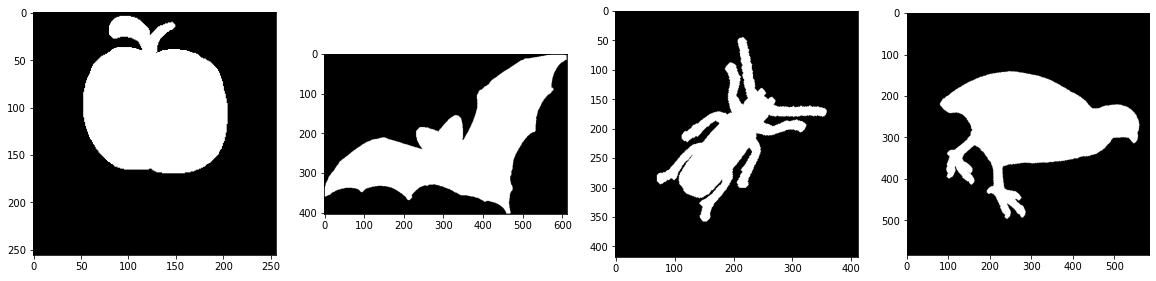

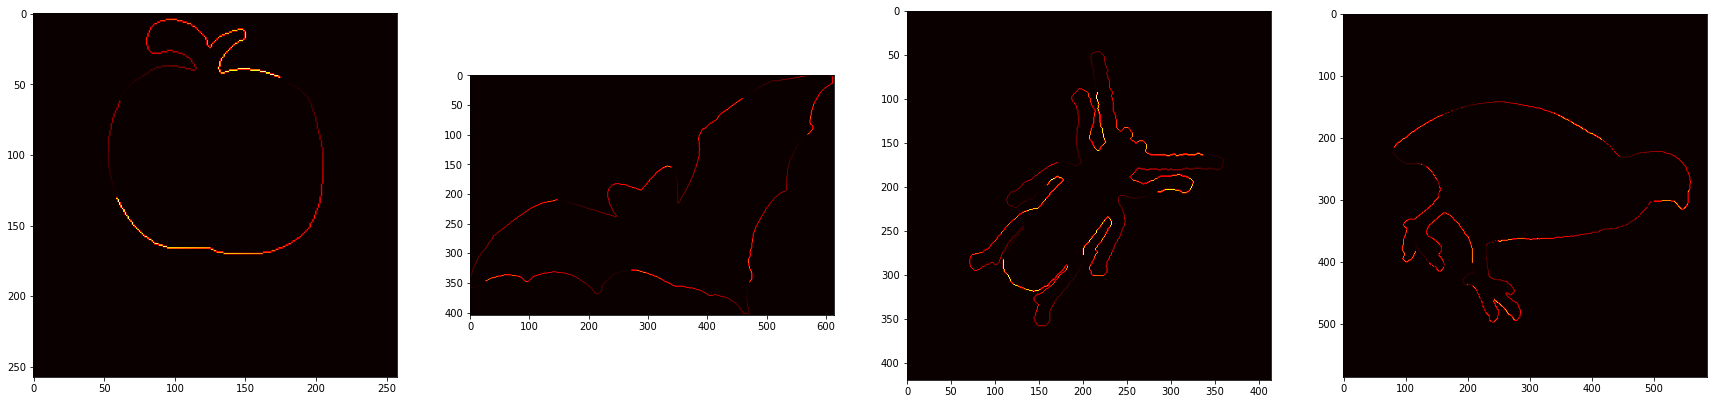

In [14]:
mask = np.array([[ 0, 1, 0 ],
                 [ 1, 1, 1 ],
                 [ 0, 1, 0 ]], dtype='uint8' )

opn = opening( mask )

fig = plt.figure(figsize=(20, 10))
imgs = []
i=1
for path in images_path:
    img = rescale(cv.imread(path, 0), 0,1)
    for d in range(3):
        img = opn.run( img )
    imgs += [ pad(img, 1,1,1,1) ]
    fig.add_subplot(1, 4, i)
    plt.imshow(img, cmap='gray')
    i+=1

fig = plt.figure(figsize=(30, 30))
for (i,img) in enumerate(imgs):
    contour_points, s = contour_ordering( img, find_start_point(img), preprocessing=get_contour,
                                         max_iterations=5000 )
    contour = points_to_img(contour_points, img.shape)
    
    print('img',i+1,'- contorno completo?:',s)
    
    fig.add_subplot(1, 4, i+1)
    plt.imshow(contour, cmap='hot')

### Exercício 2:

**Implemente o código de Freeman invariante à rotação, ponto
inicial e à escala.**

- **Use como estratégia de invariância à escala N sub-amostragens com espaçamento fixo de x pixels**
- **Crie a máscara para 10 objetos diferentes com um contorno cada (escolha as imagens com objetos de forma variada)**
- **Extraia o código de Freeman invariante de cada um dos objetos**
- **Use uma métrica (ex.: L2) para comparar os códigos**
- **Apresente os contornos em ordem de semelhança para cada objeto.**
- **Analise os resultados quanto à invariância e à eficiência**

A seguir será mostrada a implementação do código de freeman realizada.

Foram utilizadas 8 direções possíveis, numeradas de 0 a 7 no sentido anti-horário a partir do leste.
A direção é calculada a partir da aproximação do ângulo entre dois pontos.

É utilizada uma sub-amostragem de pontos do contorno para se obter uma representação com quantidade de elementos fixa, e evitar distorções por ruído.

Para gerar invariância a rotação, é calculada a diferença de rotação entre elementos consecutivos, e para gerar invariância ao ponto inicial, a sequência, que é circular, é rotacionada para gerar o maior valor possível.

In [18]:
#realiza a amostragem de n pontos de um contorno
def point_sampling( points, n ):
    sample = []
    step = len(points)/n
    
    for i in range(n):
        sample += [ points[int(i*step)] ]
    return sample

#dado 2 pontos p1 e p2, atribui um codigo de 0 a 7 que indica a direção aproximada de p2 em relação a p1
#em sentido horário
def get_code( p1, p2 ):
    a = np.array(p1)
    b = np.array(p2)
    sub = abs(a-b)
    arctan = np.arctan2( sub[1], sub[0] )
    ang = np.rad2deg(-arctan+0.5*np.pi)
    
    ang = np.round(ang/45)*45

    if   p1[0]>=p2[0] and p1[1]<=p2[1]:
        ang +=0
    elif p1[0]> p2[0] and p1[1]> p2[1]:
        ang = 180-ang
    elif p1[0]<=p2[0] and p1[1]>=p2[1]:
        ang +=180
    elif p1[0]< p2[0] and p1[1]< p2[1]:
        ang = 360-ang
    
    return int(ang/45)

#retorna a código de freeman de uma sequência de pontos
def freeman_chain_code( points ):
    chain_code = []
    last_p = points[-1]
    for p in points:
        chain_code += [get_code(last_p, p)]
        last_p = p  
    return chain_code

#altera uma sequência gerada pelo código de freeman para que seja armazenado
#a diferença de rotação entre elementos consecutivos. Garante invariância a
#rotação.
def freeman_dif( chain_code ):
    chain_dif = []
    last_code = chain_code[-1]
    for code in chain_code:
        dif = abs(code-last_code)
        if dif > 4:
            dif = 8-dif
        chain_dif += [dif]
        last_code = code
    return chain_dif

#compara duas cadeias, é retorna 1 se a segunda representar um valor maior
def compare_freeman_value( chain1, chain2 ):
    for i in range(len(chain1)):     
        if chain1[i] > chain2[i]:
            return 0
        elif chain1[i] < chain2[i]:
            return 1
    return 0

In [19]:
#rotaciona a cadeia para que ele tenha o maior valor possível. Gera invariância ao ponto inicial 
def freeman_initial_point_invariante( chain_code ):
    best_chain = chain_code
    for i in range(1,len(chain_code)):
        new_chain = chain_code[-i:] + chain_code[:-i]
        if compare_freeman_value(best_chain, new_chain):
            best_chain = new_chain
    return best_chain

Abaixo são mostrados as 10 imagens escolhidas para rodar os experimentos. Elas também pertencem ao conjunto de dados MPEG7 shapes usada no exercio anterior.

Foram escolhidas duas imagens de cada classe, sendo elas, maçã, morcego, besouro,pássaro e borboleta.

O objetivo do experimento é tentar encontrar uma imagem a partir da outra da mesma classe.

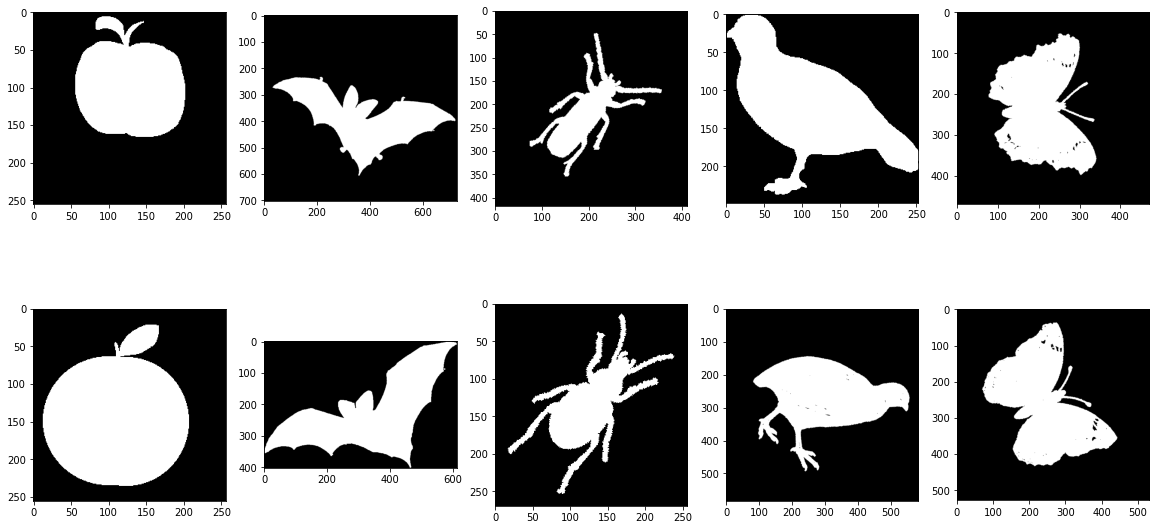

In [19]:
images_path = [ 'data/aula10/MPEG7shapes/apple-4.png',
                'data/aula10/MPEG7shapes/bat-5.png',
                'data/aula10/MPEG7shapes/beetle-10.png',
                'data/aula10/MPEG7shapes/bird-2.png',
                'data/aula10/MPEG7shapes/butterfly-6.png',
                'data/aula10/MPEG7shapes/apple-14.png',
                'data/aula10/MPEG7shapes/bat-18.png',
                'data/aula10/MPEG7shapes/beetle-12.png',
                'data/aula10/MPEG7shapes/bird-6.png',
                'data/aula10/MPEG7shapes/butterfly-13.png']

fig = plt.figure(figsize=(20, 10))
i=1
imgs = []
for path in images_path:
    img = pad(img,1,1,1,1)
    img = rescale(cv.imread(path, 0), 0,1)
    imgs += [img]
    fig.add_subplot(2, 5, i)
    plt.imshow(img, cmap='gray')
    i+=1

Para poder realizar a extração do código de Freeman, foi necessário extrair o contorno da imagem. 
Para isso foi usado o metodo de ordenação de controno do exercício anterior. Como pode ser visto,
o processo teve sucesso para todas as imagens. Não foi necessário usar extratégias para remover contornos finos. 

img 1 - contorno completo?: True
img 2 - contorno completo?: True
img 3 - contorno completo?: True
img 4 - contorno completo?: True
img 5 - contorno completo?: True
img 6 - contorno completo?: True
img 7 - contorno completo?: True
img 8 - contorno completo?: True
img 9 - contorno completo?: True
img 10 - contorno completo?: True


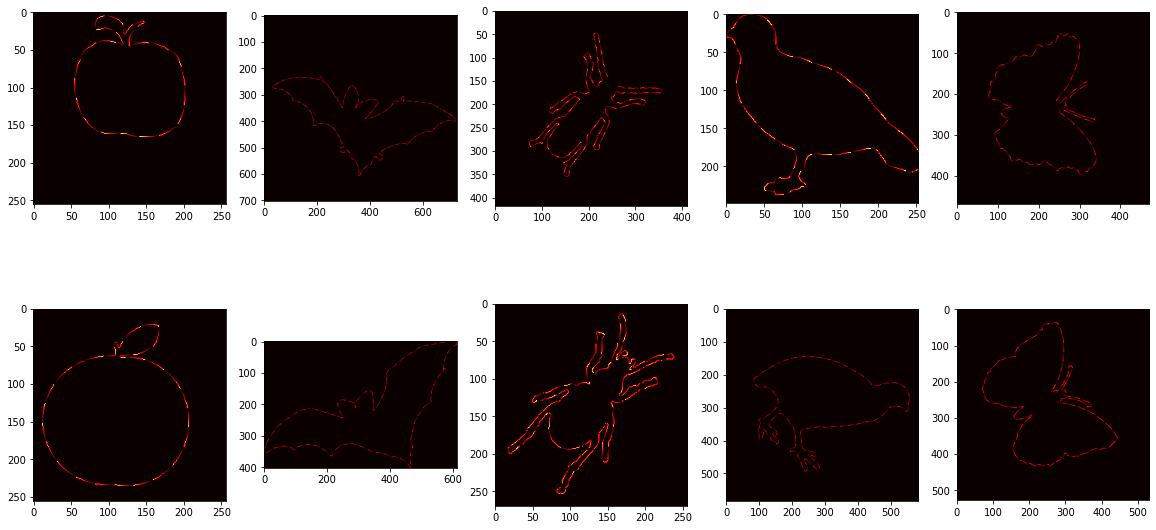

In [27]:
fig = plt.figure(figsize=(20, 10))

imgs_points = []
shapes = []
for (i,img) in enumerate(imgs):
    contour_points, s = contour_ordering( img, find_start_point(img), preprocessing=get_contour, max_iterations=5000 )
    imgs_points += [contour_points]
    shapes += [img.shape]
    contour = points_to_img(contour_points, img.shape, h=10)
    
    print('img',i+1,'- contorno completo?:',s)
    
    fig.add_subplot(2, 5, i+1)
    plt.imshow(contour, cmap='hot')

Os contornos foram amostrados, mantendo 200 pontos de cada um, como pode ser visto abaixo.

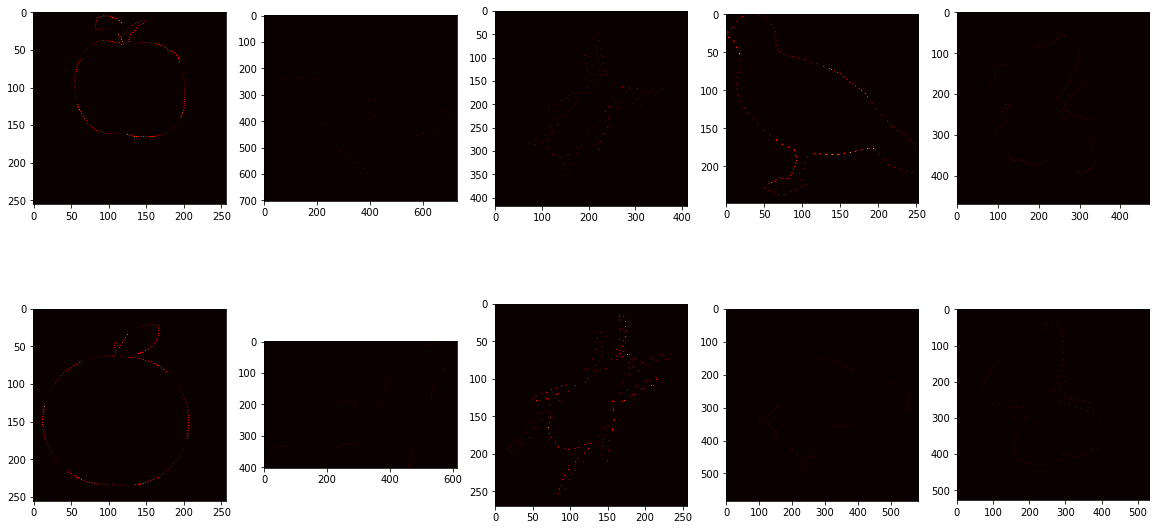

In [32]:
sampled_points = []
n_samples = 200
fig = plt.figure(figsize=(20, 10))
for i, points in enumerate(imgs_points):
    sample = point_sampling( points, n_samples ) 
    sampled_points += [sample] 
    contour = points_to_img(sample, shapes[i], h=10)
    fig.add_subplot(2, 5, i+1)
    plt.imshow(contour, cmap='hot', vmin=0)

Foi então extraído o código de Freeman de cada sequência de 200 pontos, sendo aplicados os métodos citados anteriormente para deixar a cadeia invariante à rotação e ponto inicial.

In [33]:
features = []
for i, sample in enumerate(sampled_points):
    chain_code = freeman_chain_code( sample )
    chain_dif  = freeman_dif( chain_code )
    feature = freeman_initial_point_invariante( chain_dif )
    features += [feature]
    print('img',i,':')
    print('chain code:', chain_code[:10])
    print('dif:', chain_dif[:10])
    print('dif init. p. inv.:', feature[:10], '\n')
    

img 0 :
chain code: [2, 2, 1, 2, 1, 1, 1, 1, 1, 1]
dif: [1, 0, 1, 1, 1, 0, 0, 0, 0, 0]
dif init. p. inv.: [3, 0, 0, 0, 0, 0, 1, 0, 0, 0] 

img 1 :
chain code: [1, 6, 7, 7, 7, 7, 7, 1, 2, 2]
dif: [1, 3, 1, 0, 0, 0, 0, 2, 1, 0]
dif init. p. inv.: [3, 3, 1, 3, 2, 0, 0, 0, 2, 1] 

img 2 :
chain code: [0, 8, 1, 2, 2, 2, 2, 1, 7, 6]
dif: [1, 0, 1, 1, 0, 0, 0, 1, 2, 1]
dif init. p. inv.: [4, 0, 1, 1, 1, 2, 1, 0, 0, 0] 

img 3 :
chain code: [1, 1, 1, 0, 8, 8, 7, 7, 6, 6]
dif: [0, 0, 0, 1, 0, 0, 1, 0, 1, 0]
dif init. p. inv.: [4, 1, 0, 0, 0, 1, 0, 0, 1, 0] 

img 4 :
chain code: [1, 0, 0, 1, 1, 0, 1, 0, 8, 8]
dif: [1, 1, 0, 1, 0, 1, 1, 1, 0, 0]
dif init. p. inv.: [3, 1, 0, 1, 1, 1, 1, 0, 3, 1] 

img 5 :
chain code: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dif: [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
dif init. p. inv.: [4, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

img 6 :
chain code: [0, 8, 8, 8, 8, 8, 8, 8, 8, 8]
dif: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
dif init. p. inv.: [3, 1, 3, 1, 0, 0, 0, 0, 0, 1] 

img 7 :
chain code: [0, 0, 

As funções a seguir foram usadas para encontrar as $n$ imagens mais similares, levando em conta seus vetores de características.

In [34]:
def most_similar( features, i,  weights=None):
    out = []
    dist = np.zeros( len(features) )
    for j in range( len(features) ):
        dist[j] = euclidean( features[i], features[j] )
    similar = np.argsort(dist)
    return similar

def serch_and_plot(features, imgs, index,n=3):
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle('Imagem pesquisada', y=0.65, fontsize=16)

    fig.add_subplot(1, 5, 2 )
    plt.imshow( imgs[index], cmap='gray' )

    similars = most_similar( features, index)
    fig = plt.figure(figsize=(20, 10))
    fig.suptitle('Imagens mais similares', y=0.73, fontsize=16)
    for i in range(1,n+1):
        fig.add_subplot(1, 5, i )
        plt.imshow( imgs[ similars[i] ], cmap='gray' )

A seguir serão mostrados as 3 imagens mais similares encontradas a partir de uma imagem de cada classe. O objetivo era encontrar a outra imagem da mesma classe.

Como pode ser visto, apenas com a maçã foi possível encontrar a outra imagem no conjunto de dados na posição 1.

Levando em consideração as 3 posições, foi possivel encontrar a imagem do pássaro também.

Sendo concluído que o descritor não apresentou resultados muito bons para a tarefa, acertando apenas algumas imagens.


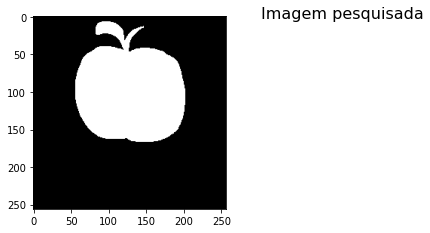

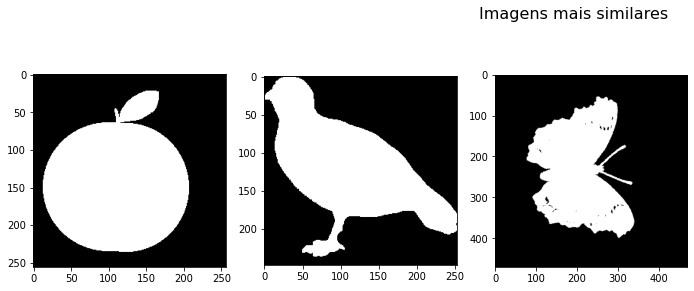

In [35]:
serch_and_plot(features, imgs, 0)

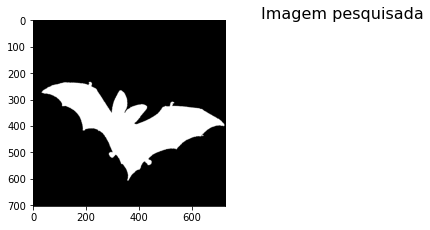

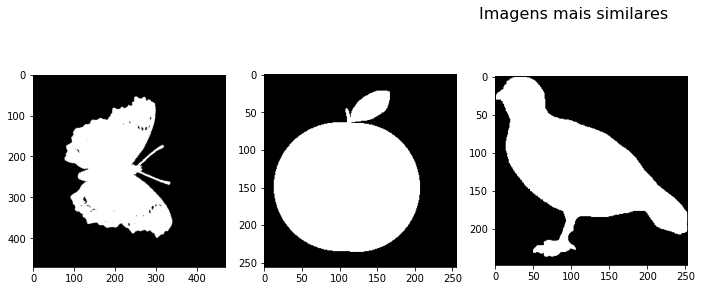

In [36]:
serch_and_plot(features, imgs, 1)

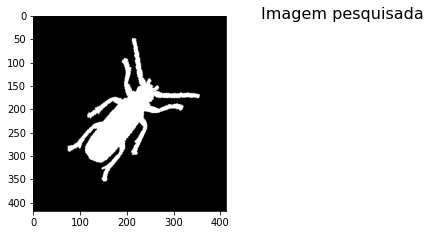

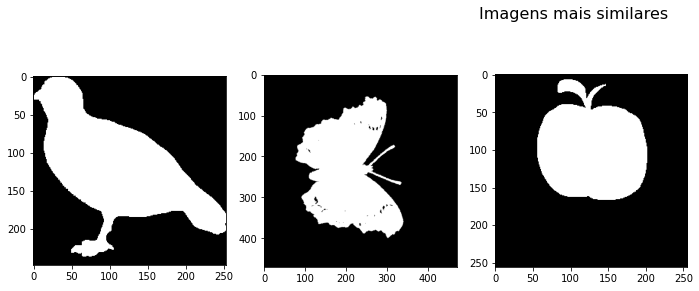

In [37]:
serch_and_plot(features, imgs, 2)

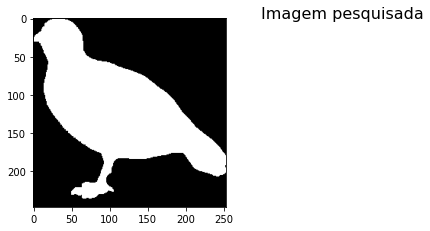

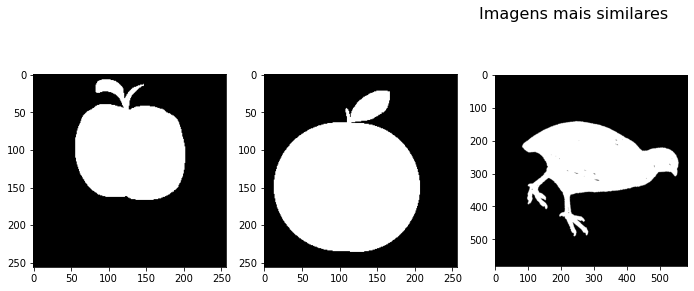

In [38]:
serch_and_plot(features, imgs, 3)

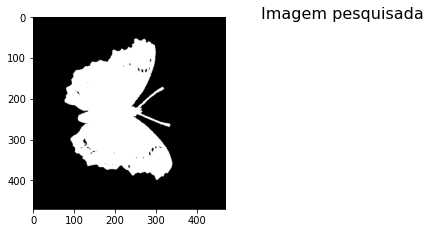

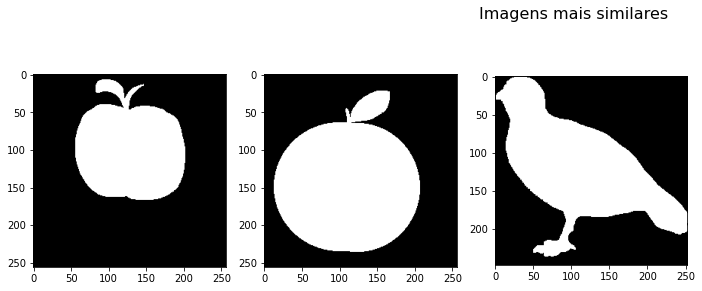

In [39]:
serch_and_plot(features, imgs, 4)

### Exercício 3:

**Teste um algoritmo a assinatura invariante pelo histograma (pode escolher o tipo)**

- **Pode implementar, ou usar implementação pronta de assinatura invariante**
- **Use vetores de mesmo tamanho**
- **Use as mesmas imagens/objetos do exercício anterior do código de Freeman**
- **Analise os resultados e compare com o Freeman**

Inicialmente foi calculado o centroide de cada contorno, como é mostrado a seguir.

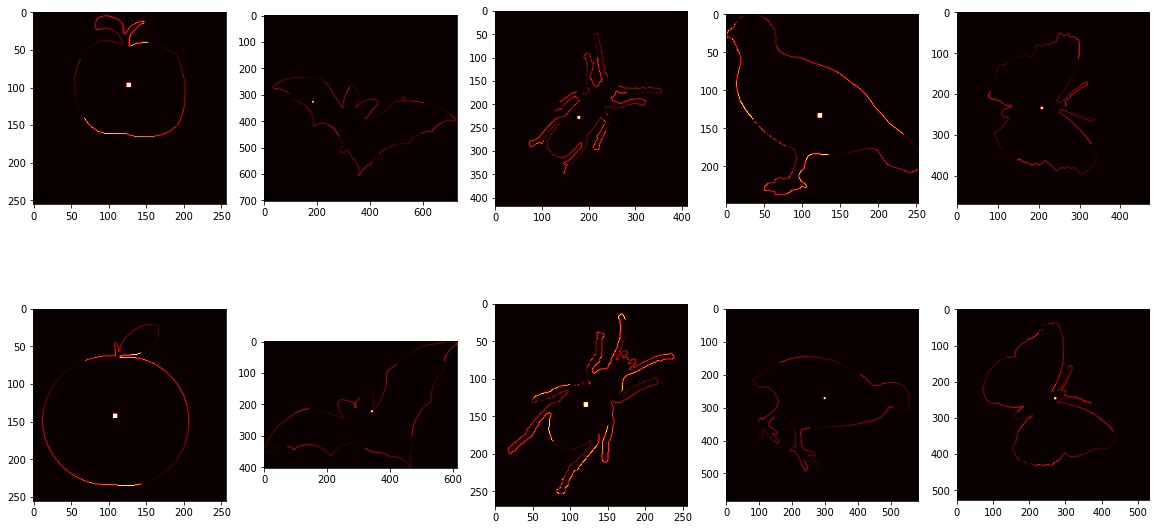

In [279]:
centroids = []
fig = plt.figure(figsize=(20, 10))
for i, sample in enumerate(imgs_points):
    M = cv.moments(np.array(sample))
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids += [[cX, cY]]
    img = points_to_img(sample, shapes[i])
    value = img.max()
    for k in range( -3,3 ):
        for l in range( -3,3 ):
            img[ cX+k, cY+l ] = value
    
    fig.add_subplot(2, 5, i+1)
    plt.imshow(img, cmap='hot')

As funções abaixo foram usadas para calcular os ângulos em relação o centroide e todos os pontos dos contorno.

In [280]:
def get_angle( p1, p2 ):
    a = np.array(p1)
    b = np.array(p2)
    sub = abs(a-b)
    arctan = np.arctan2( sub[1], sub[0] )
    ang = np.rad2deg(-arctan+0.5*np.pi)
    
    if   p1[0]>=p2[0] and p1[1]<=p2[1]:
        ang +=0
    elif p1[0]> p2[0] and p1[1]> p2[1]:
        ang = 180-ang
    elif p1[0]<=p2[0] and p1[1]>=p2[1]:
        ang +=180
    elif p1[0]< p2[0] and p1[1]< p2[1]:
        ang = 360-ang
        
    return ang

def contour_angles( center, contour ):
    angles = []
    for point in contour:
        angles += [ get_angle( center, point ) ]
    return angles

imgs_angles = []

for (i,points) in enumerate(imgs_points):
    angles = contour_angles( centroids[i], points )
    imgs_angles += [ angles ]

Abaixo é mostrado a implementação da assinatura, onde são escolhidos $n$ angulos, sendo encontrado o primeiro ponto nessa direção e caculado a sua distância em relação o centroide.

Para deixar as caracteristicas invariantes à rotação antes de calcular a assinatura, a lista de pontos são rotacionados de modo a deixar o maior ângulo primeiro.

Para deixar a assinatura invariante a escala, os valores da assinatura são normalizados para variar entre 0 e 1.

In [325]:
def signature(centroid, contour, angles, n):
    sign =[]
    sorted_angs = np.argsort(angles)

    for ang in np.linspace(0,360, n):        
        for j in range(1, len(angles)):
            index = sorted_angs[j]
            last_index = sorted_angs[j-1]
            
            if ang < angles[index]:
                if abs(ang-angles[index]) < abs(ang-angles[last_index]):
                    sign += [ euclidean( centroid, contour[ index ] ) ]
                    #print(ang, angles[index], index)
                else:
                    sign += [ euclidean( centroid, contour[ last_index ] ) ]
                    #print(ang, angles[last_index], last_index)
                break
    return sign

def rotation_inv( contour, angles ):
    m = np.argmax( angles )
    return (contour[m:] + contour[:m], angles[m:] + angles[:m]  )

def scale_inv( sign ):
    return rescale(np.array(sign), 0,1)

A seguir é mostrado um trecho da assinatura extraída de cada contorno. Foram usados 200 ângulos igualmente espaçados.

In [328]:
signatures = []

for (i,points) in enumerate(imgs_points):
    inv_points, inv_angles = rotation_inv( points, imgs_angles[i] )
    s = signature(centroids[i], inv_points, inv_angles, 200)
    s = scale_inv(s)
    signatures += [s]
    print( 'img',i,'-',s[:10] )
    

img 0 - [0.46064844 0.46124359 0.44239075 0.44599873 0.45079688 0.43499925
 0.42468488 0.43378924 0.4227054  0.4342431 ]
img 1 - [0.71756608 0.12651551 0.27587917 0.17049618 0.17330237 0.11488706
 0.18155682 0.11095453 0.10615624 0.19939574]
img 2 - [0.1513974  0.24376463 0.24440082 0.23890755 0.22652872 0.21528811
 0.74686967 0.70577201 0.62412939 0.32912479]
img 3 - [0.27417841 0.25752404 0.24127779 0.21699472 0.20180132 0.19565569
 0.18161672 0.17847973 0.17215658 0.16005524]
img 4 - [0.11952406 0.1197506  0.12698571 0.12809541 0.11576652 0.12408556
 0.12631837 0.12257108 0.11935407 0.1292572 ]
img 5 - [0.32523879 0.3261174  0.30984377 0.31426963 0.30165221 0.30964682
 0.30076175 0.29382091 0.2888468  0.28585573]
img 6 - [0.40905546 0.42078161 0.43007023 0.44862481 0.46767977 0.49898615
 0.51379125 0.51731228 0.52485023 0.53220747]
img 7 - [0.05302221 0.05316753 0.17259811 0.04448311 0.20490212 0.27757667
 0.30046133 0.345208   0.43136087 0.63342056]
img 8 - [1.         0.99486877 0

A seguir é mostrado o resultado da pesquisa de uma imagem de cada classe, da mesma forma que o exercício 2, mas usando a assinatura.

Como pode ser observado, foram obtidos bons resultados, sendo capaz de recuperar a outra imagem da mesma classe em 4 casos.

A única imagem em que isso não ocorreu foi a do morcego. 
Um possível motivo para o ocorrido foi a posição do centroide encontrada, que está em locais muito diferentes nas duas imagens.

No geral pode ser concluído que os resultados da assinatura foram melhores do que os do código de Freeman.

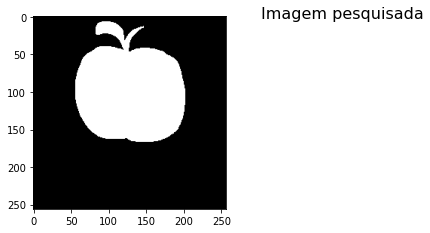

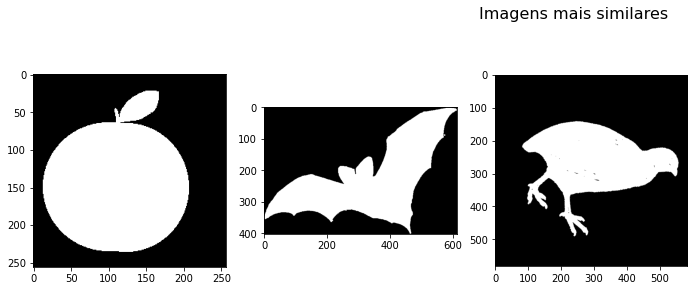

In [329]:
serch_and_plot(signatures, imgs, 0)

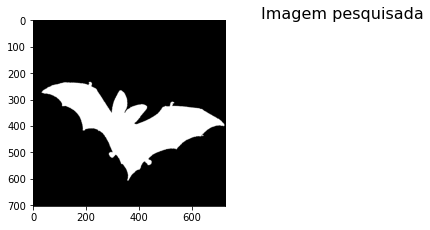

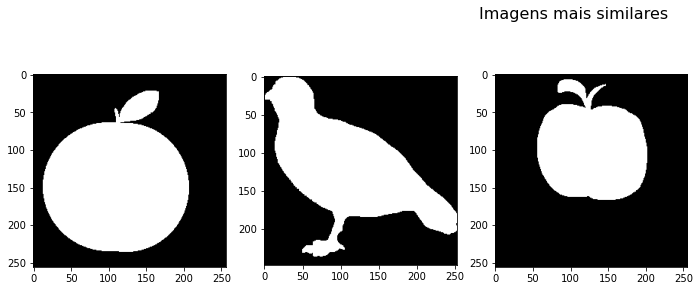

In [330]:
serch_and_plot(signatures, imgs, 1)

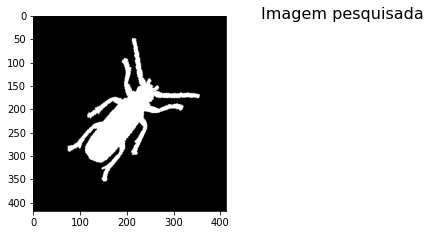

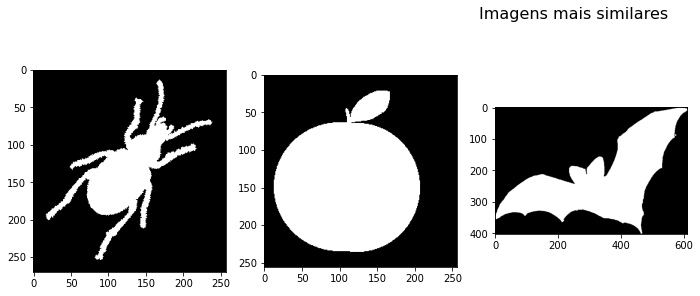

In [331]:
serch_and_plot(signatures, imgs, 2)

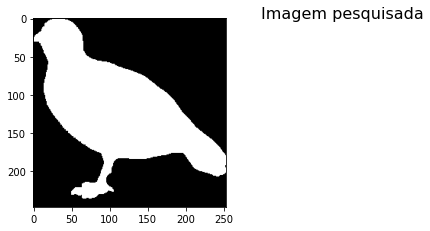

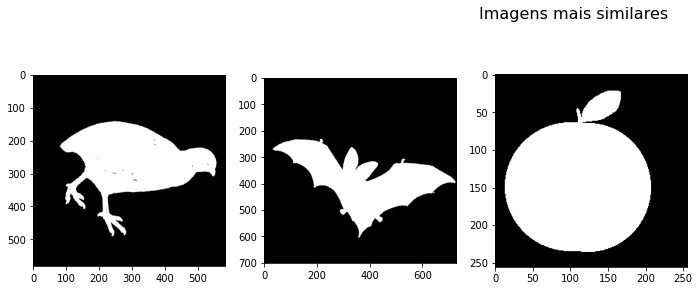

In [332]:
serch_and_plot(signatures, imgs, 3)

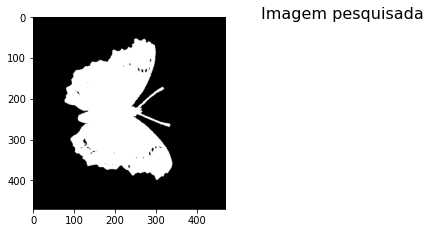

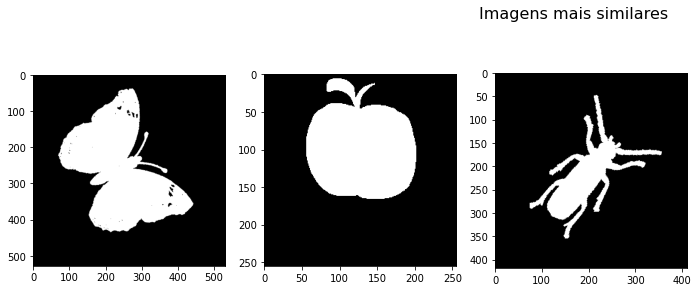

In [333]:
serch_and_plot(signatures, imgs, 4)